In [2]:
# ! nvidia-smi
from keras.datasets import cifar10
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0, False)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

C:\Users\Mohsen\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Q1 - MLP (Classification)

## Download & Visualize

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

In [ ]:
def plot_pics(x: np.ndarray, y: np.ndarray):
    fig = plt.figure(figsize=(15, 4))
    for class_num in range(10):
        class_indices = np.where(y == class_num)[0]
        class_x = x[class_indices]
        rnd_idx = np.random.randint(len(class_x))
        image = class_x[rnd_idx]
        ax = fig.add_subplot(1, 10, class_num + 1, xticks=[], yticks=[])
        ax.set_title(class_num)
        plt.imshow(image)
    plt.show()

for i in range(3):
    plot_pics(x_train, y_train)

## Preprocessing

In [ ]:
def onehot(a):
    a = a.flatten()
    o = np.zeros((a.size, a.max() + 1))
    o[np.arange(a.size), a] = 1
    return o

def preprocess(x, y):
    assert x.shape[1:] == (32, 32, 3)
    assert y.shape[1:] == (1, )
    x = np.mean(x, axis=-1)  # grayscale
    x = np.reshape(x, (-1, 32 * 32))  # flatten
    x /= 255  # normalize
    y = onehot(y)  # onehot labels
    return x, y

x_train_processed, y_train_processed = preprocess(x_train, y_train)
x_test_processed, y_test_processed = preprocess(x_test, y_test)
x_train_processed.shape, y_train_processed.shape

## Model & Training

In [119]:
class Trainer:
    def __init__(self, units=1024, activation_function="relu", 
                 optimizer="adam", n_layers=4, loss_function='categorical_crossentropy', input_size=1024) -> None:
        self.optimizer = optimizer
        self.units = units
        self.activation_function = activation_function
        self.n_layers = n_layers
        self.loss_function = loss_function
        self.input_size = input_size
        self.model = self.build_mlp_model()
        self.history = None
        self.training_time = None
        
    
    def print_summary(self):
        print("######################")
        print(f"Training Time: {self.training_time:.2f}s")
        print("batch size:", self.batch_size)
        print("n_layers:", self.n_layers)
        print("optimizer:", self.optimizer)
        print("activation_function:", self.activation_function)
        print("loss_function", self.loss_function)
        print(self.model.summary())

    def build_mlp_model(self):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=(self.input_size, ))])
        for n in range(self.n_layers):
            model.add(tf.keras.layers.Dense(self.units / 2**n, activation=self.activation_function))
            model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['accuracy']
        )
        return model
    
    def train(self, x_train, y_train, batch_size=32, epochs=50):
        self.batch_size = batch_size
        assert x_train.shape[1:] == (self.input_size, )
        assert y_train.shape[1:] == (10, )
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=10,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()

    
    def evaluate(self, x_test, y_test):
        assert x_test.shape[1:] == (self.input_size, )
        assert y_test.shape[1:] == (10, )
        [test_loss,test_acc] = self.model.evaluate(x_test,y_test)
        print("Test Loss:", test_loss, "Test Accuracy:", test_acc)
        test_preds = np.argmax(self.model.predict(x_test), axis=-1)
        y_test = np.argmax(y_test, axis=-1)
        print(classification_report(y_test, test_preds))
        self.plot_cm(y_test, test_preds)
    
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

In [ ]:
for n_units in [128, 1024, 2048]:
    trainer = Trainer(
        units=n_units,
        activation_function="relu", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
        n_layers=4
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=64, 
                  epochs=100)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
for batch_size in [32, 64, 128, 512]:
    trainer = Trainer(
        units=1024,
        activation_function="relu", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
        n_layers=4
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=batch_size, 
                  epochs=200)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
for activation_function in ["softmax", "sigmoid", "tanh", "relu"]:
    trainer = Trainer(
        units=1024,
        activation_function=activation_function, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
        n_layers=4
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=128, 
                  epochs=500)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
for loss_function in ["cosine_similarity", "kl_divergence", "mean_squared_error", "categorical_crossentropy"]:
    trainer = Trainer(
        units=1024,
        activation_function="relu", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        n_layers=4,
        loss_function = loss_function
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=128, 
                  epochs=500)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
optimizers = [
    tf.keras.optimizers.SGD(learning_rate=1e-2),
    tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    tf.keras.optimizers.Adam(learning_rate=2e-4)
]
for optimizer in optimizers:
    trainer = Trainer(
        units=1024,
        activation_function="relu", 
        optimizer=optimizer, 
        n_layers=4,
        loss_function = "kl_divergence"
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=128, 
                  epochs=500)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
for n_layers in [3, 4, 5]:
    trainer = Trainer(
        units=1024,
        activation_function="relu", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
        n_layers=n_layers,
        loss_function = "kl_divergence"
    )
    trainer.train(x_train_processed, y_train_processed, 
                  batch_size=128, 
                  epochs=500)
    trainer.print_summary()
    trainer.plot_history()
    trainer.evaluate(x_test_processed, y_test_processed)

In [ ]:
### BEST
trainer = Trainer(
    units=1024,
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
    n_layers=4,
    loss_function = "kl_divergence"
)
trainer.train(x_train_processed, y_train_processed, 
              batch_size=128, 
              epochs=500)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed, y_test_processed)

# Q2 - MLP (Regression)

In [8]:
raw_df = pd.read_csv('data.csv')
for col in raw_df.columns:
    print(f"({col}, {len(raw_df[col].unique())})", end=", ")
raw_df

(date, 70), (price, 1741), (bedrooms, 10), (bathrooms, 26), (sqft_living, 566), (sqft_lot, 3113), (floors, 6), (waterfront, 2), (view, 5), (condition, 5), (sqft_above, 511), (sqft_basement, 207), (yr_built, 115), (yr_renovated, 60), (street, 4525), (city, 44), (statezip, 77), (country, 1), 

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


## a)

In [138]:
# Objects to Numbers
df = raw_df.copy()
CATEGORICAL_COLS = ["street", "city", "statezip", "country", "condition"]
for col in CATEGORICAL_COLS:
    one_hot_df = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([
        df.drop(columns=col),
        one_hot_df
    ], axis=1)
df["date"] = pd.to_datetime(df["date"]).apply(lambda x: x.value)
df["date"] = (df["date"] - df["date"].mean()) / df["date"].std()  # Normalize 
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,...,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,country_USA,condition_1,condition_2,condition_3,condition_4,condition_5
0,-1.833514,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,1340,...,0,0,0,0,1,0,0,1,0,0
1,-1.833514,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,3370,...,0,0,0,0,1,0,0,0,0,1
2,-1.833514,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,1930,...,0,0,0,0,1,0,0,0,1,0
3,-1.833514,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,1000,...,0,0,0,0,1,0,0,0,1,0
4,-1.833514,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,1140,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,1.616831,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,1510,...,0,0,0,0,1,0,0,0,1,0
4596,1.616831,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,1460,...,0,0,0,0,1,0,0,1,0,0
4597,1.616831,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3010,...,0,0,0,0,1,0,0,1,0,0
4598,1.667571,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,1070,...,0,0,0,0,1,0,0,1,0,0


In [139]:
# Missing Values
print(raw_df.isnull().sum())
print(raw_df[raw_df==0].count())

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64
date                0
price              49
bedrooms            2
bathrooms           2
sqft_living         0
sqft_lot            0
floors              0
waterfront       4567
view             4140
condition           0
sqft_above          0
sqft_basement    2745
yr_built            0
yr_renovated     2735
street              0
city                0
statezip            0
country             0
dtype: int64


In [140]:
df = df.loc[df['price'] != 0]
df['yr_renovated'] = df['yr_renovated'].replace(0, np.NaN)
df['yr_renovated'].fillna((df['yr_renovated'].mean()), inplace=True)
df

C:\Users\Mohsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Mohsen\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,...,statezip_WA 98198,statezip_WA 98199,statezip_WA 98288,statezip_WA 98354,country_USA,condition_1,condition_2,condition_3,condition_4,condition_5
0,-1.833514,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,1340,...,0,0,0,0,1,0,0,1,0,0
1,-1.833514,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,3370,...,0,0,0,0,1,0,0,0,0,1
2,-1.833514,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,1930,...,0,0,0,0,1,0,0,0,1,0
3,-1.833514,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,1000,...,0,0,0,0,1,0,0,0,1,0
4,-1.833514,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,1140,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,1.616831,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,1510,...,0,0,0,0,1,0,0,0,1,0
4596,1.616831,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,1460,...,0,0,0,0,1,0,0,1,0,0
4597,1.616831,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3010,...,0,0,0,0,1,0,0,1,0,0
4598,1.667571,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,1070,...,0,0,0,0,1,0,0,1,0,0


In [141]:
print(df[df==0].count()[:15])

date                         0
price                        0
bedrooms                     2
bathrooms                    2
sqft_living                  0
sqft_lot                     0
floors                       0
waterfront                4521
view                      4103
sqft_above                   0
sqft_basement             2718
yr_built                     0
yr_renovated                 0
street_1 View Ln NE       4550
street_10 W Etruria St    4550
dtype: int64


In [142]:
x = df.drop(columns='price').to_numpy()
y = df['price'].to_numpy()
x.shape, y.shape

((4551, 4664), (4551,))

## b)

In [143]:
x_train, x_test, y_train, y_test = train_test_split(x, np.log(y), test_size=0.2, random_state=42)

In [177]:
class TrainerRegression:
    def __init__(self, units=1024, activation_function="relu", 
                 optimizer="adam", n_layers=4, loss_function='mean_squared_error') -> None:
        self.optimizer = optimizer
        self.units = units
        self.activation_function = activation_function
        self.n_layers = n_layers
        self.loss_function = loss_function
        self.model = self.build_mlp_model()
        self.history = None
        self.training_time = None
    
    def print_summary(self):
        print("######################")
        print(f"Training Time: {self.training_time:.2f}s")
        print("batch size:", self.batch_size)
        print("n_layers:", self.n_layers)
        print("optimizer:", self.optimizer)
        print("activation_function:", self.activation_function)
        print("loss_function", self.loss_function)
        print(self.model.summary())

    def build_mlp_model(self):
        model = tf.keras.Sequential([
#             tf.keras.layers.Input(shape=(4664, )),
            tf.keras.layers.Normalization()
        ])
        model.add(tf.keras.layers.LayerNormalization())
        for n in range(self.n_layers):
            model.add(tf.keras.layers.Dense(self.units / 2**n))
            model.add(tf.keras.layers.LayerNormalization())
            model.add(tf.keras.layers.Activation(self.activation_function))
            model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(1))
        
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['mean_squared_error', 'mean_absolute_error']
        )
        return model
    
    def train(self, x_train, y_train, batch_size=32, epochs=50):
        self.batch_size = batch_size
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=10,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.15,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(14, 3))
        metrics = ['loss', 'mean_squared_error', 'mean_absolute_error']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 3, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()

    
    def evaluate(self, x_test, y_test):
        [test_loss, test_mse, test_mae] = self.model.evaluate(x_test, y_test)
        print("Test Loss:", test_loss, 
              "Test MSE:", test_mse,
              "Test MAE:", test_mae
        )
        preds = self.model.predict(x_test)
        plt.title('Targets vs. Predictions')
        plt.scatter(y_test, preds)
        plt.xlabel('Target')
        plt.ylabel('Prediction')
        plt.show()

Epoch 1/200
49/49 [==============================] - 1s 15ms/step - loss: 7.4895 - mean_squared_error: 7.4895 - mean_absolute_error: 1.6381 - val_loss: 0.3258 - val_mean_squared_error: 0.3258 - val_mean_absolute_error: 0.4497
Epoch 2/200
49/49 [==============================] - 0s 9ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - mean_absolute_error: 0.4435 - val_loss: 0.2006 - val_mean_squared_error: 0.2006 - val_mean_absolute_error: 0.3460
Epoch 3/200
49/49 [==============================] - 0s 9ms/step - loss: 0.2714 - mean_squared_error: 0.2714 - mean_absolute_error: 0.4073 - val_loss: 0.1864 - val_mean_squared_error: 0.1864 - val_mean_absolute_error: 0.3332
Epoch 4/200
49/49 [==============================] - 0s 8ms/step - loss: 0.2594 - mean_squared_error: 0.2594 - mean_absolute_error: 0.3936 - val_loss: 0.1908 - val_mean_squared_error: 0.1908 - val_mean_absolute_error: 0.3535
Epoch 5/200
49/49 [==============================] - 0s 9ms/step - loss: 0.2389 - mean_squared_erro

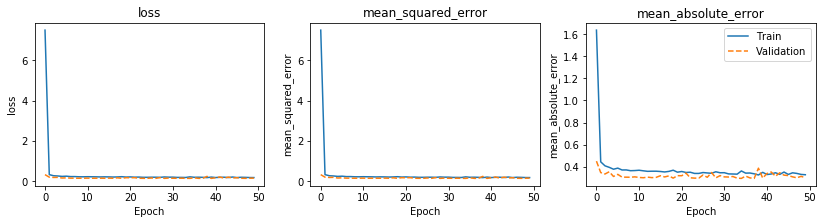

29/29 [==============================] - 0s 3ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - mean_absolute_error: 0.2970
Test Loss: 0.14103904366493225 Test MSE: 0.14103904366493225 Test MAE: 0.2970487177371979


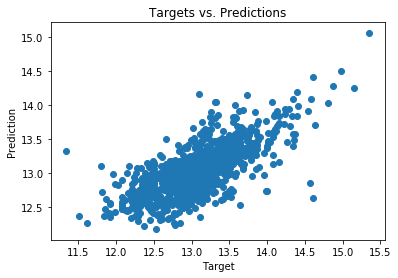

In [180]:
for n_layer in [3]:
    trainer_reg = TrainerRegression(
        units=2048,
        activation_function="relu", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
        n_layers=n_layer
    )
    trainer_reg.train(x_train, y_train, 
                      batch_size=64,
                      epochs=200)
    trainer_reg.print_summary()
    trainer_reg.plot_history()
    trainer_reg.evaluate(x_test, y_test)

Epoch 1/200
49/49 [==============================] - 2s 18ms/step - loss: 4.3272 - mean_squared_error: 4.3272 - mean_absolute_error: 0.7879 - val_loss: 0.2011 - val_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.3612
Epoch 2/200
49/49 [==============================] - 0s 9ms/step - loss: 0.2957 - mean_squared_error: 0.2957 - mean_absolute_error: 0.4203 - val_loss: 0.2197 - val_mean_squared_error: 0.2197 - val_mean_absolute_error: 0.3580
Epoch 3/200
49/49 [==============================] - 1s 11ms/step - loss: 0.2612 - mean_squared_error: 0.2612 - mean_absolute_error: 0.3985 - val_loss: 0.1554 - val_mean_squared_error: 0.1554 - val_mean_absolute_error: 0.3123
Epoch 4/200
49/49 [==============================] - 0s 10ms/step - loss: 0.2418 - mean_squared_error: 0.2418 - mean_absolute_error: 0.3831 - val_loss: 0.1519 - val_mean_squared_error: 0.1519 - val_mean_absolute_error: 0.3031
Epoch 5/200
49/49 [==============================] - 0s 10ms/step - loss: 0.2360 - mean_squared_e

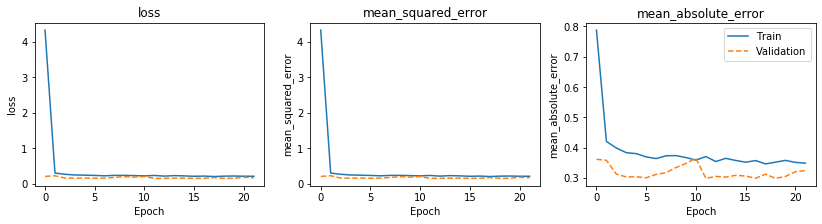

29/29 [==============================] - 0s 3ms/step - loss: 0.1445 - mean_squared_error: 0.1445 - mean_absolute_error: 0.2999
Test Loss: 0.14445987343788147 Test MSE: 0.14445987343788147 Test MAE: 0.29986485838890076


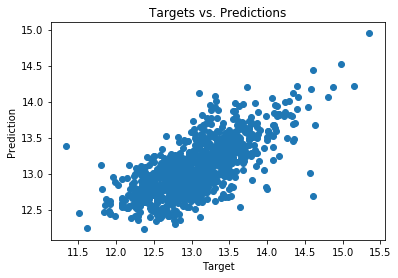

Epoch 1/200
49/49 [==============================] - 2s 15ms/step - loss: 5.0361 - mean_squared_error: 5.0361 - mean_absolute_error: 1.1167 - val_loss: 0.3425 - val_mean_squared_error: 0.3425 - val_mean_absolute_error: 0.4633
Epoch 2/200
49/49 [==============================] - 0s 10ms/step - loss: 0.3793 - mean_squared_error: 0.3793 - mean_absolute_error: 0.4841 - val_loss: 0.3012 - val_mean_squared_error: 0.3012 - val_mean_absolute_error: 0.4330
Epoch 3/200
49/49 [==============================] - 0s 9ms/step - loss: 0.3947 - mean_squared_error: 0.3947 - mean_absolute_error: 0.4859 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - val_mean_absolute_error: 0.4337
Epoch 4/200
49/49 [==============================] - 0s 9ms/step - loss: 0.3988 - mean_squared_error: 0.3988 - mean_absolute_error: 0.4896 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - val_mean_absolute_error: 0.4332
Epoch 5/200
49/49 [==============================] - 0s 10ms/step - loss: 0.3797 - mean_squared_er

49/49 [==============================] - 0s 10ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - mean_absolute_error: 0.3501 - val_loss: 0.1464 - val_mean_squared_error: 0.1464 - val_mean_absolute_error: 0.3065
Epoch 74/200
49/49 [==============================] - 0s 10ms/step - loss: 0.1976 - mean_squared_error: 0.1976 - mean_absolute_error: 0.3431 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - val_mean_absolute_error: 0.3078
Epoch 75/200
49/49 [==============================] - 0s 10ms/step - loss: 0.1955 - mean_squared_error: 0.1955 - mean_absolute_error: 0.3435 - val_loss: 0.1464 - val_mean_squared_error: 0.1464 - val_mean_absolute_error: 0.3069
Epoch 76/200
49/49 [==============================] - 0s 10ms/step - loss: 0.1968 - mean_squared_error: 0.1968 - mean_absolute_error: 0.3442 - val_loss: 0.1446 - val_mean_squared_error: 0.1446 - val_mean_absolute_error: 0.2991
Epoch 77/200
49/49 [==============================] - 1s 11ms/step - loss: 0.1900 - mean_squared_error: 0

 Layer (type)                Output Shape              Param #   
 normalization_125 (Normaliz  (None, 4664)             9329      
 ation)                                                          
                                                                 
 layer_normalization_472 (La  (None, 4664)             9328      
 yerNormalization)                                               
                                                                 
 dense_611 (Dense)           (None, 2048)              9553920   
                                                                 
 layer_normalization_473 (La  (None, 2048)             4096      
 yerNormalization)                                               
                                                                 
 activation_386 (Activation)  (None, 2048)             0         
                                                                 
 dropout_485 (Dropout)       (None, 2048)              0         
          

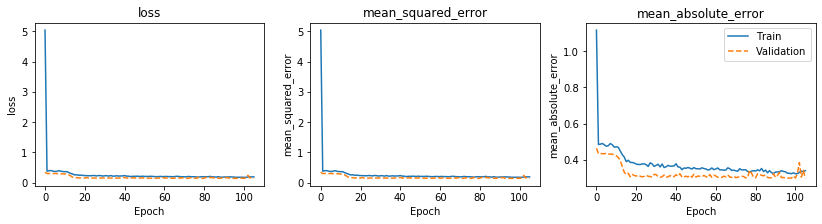

29/29 [==============================] - 0s 3ms/step - loss: 0.1422 - mean_squared_error: 0.1422 - mean_absolute_error: 0.2968
Test Loss: 0.14224666357040405 Test MSE: 0.14224666357040405 Test MAE: 0.2967800199985504


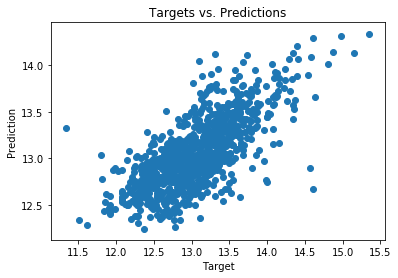

In [187]:
for activation_function in ["relu", "sigmoid"]:
    trainer_reg = TrainerRegression(
        units=2048,
        activation_function=activation_function, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
        n_layers=2
    )
    trainer_reg.train(x_train, y_train, 
                      batch_size=64,
                      epochs=200)
    trainer_reg.print_summary()
    trainer_reg.plot_history()
    trainer_reg.evaluate(x_test, y_test)

Epoch 1/200
49/49 [==============================] - 2s 19ms/step - loss: 4.2192 - mean_squared_error: 4.2192 - mean_absolute_error: 0.9859 - val_loss: 0.2372 - val_mean_squared_error: 0.2372 - val_mean_absolute_error: 0.3819
Epoch 2/200
49/49 [==============================] - 1s 11ms/step - loss: 0.2909 - mean_squared_error: 0.2909 - mean_absolute_error: 0.4188 - val_loss: 0.2170 - val_mean_squared_error: 0.2170 - val_mean_absolute_error: 0.3569
Epoch 3/200
49/49 [==============================] - 1s 10ms/step - loss: 0.2630 - mean_squared_error: 0.2630 - mean_absolute_error: 0.4010 - val_loss: 0.1953 - val_mean_squared_error: 0.1953 - val_mean_absolute_error: 0.3414
Epoch 4/200
49/49 [==============================] - 0s 10ms/step - loss: 0.2378 - mean_squared_error: 0.2378 - mean_absolute_error: 0.3770 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - val_mean_absolute_error: 0.3209
Epoch 5/200
49/49 [==============================] - 0s 10ms/step - loss: 0.2462 - mean_squared_

None


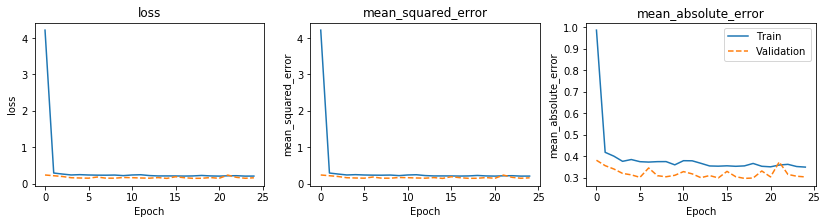

29/29 [==============================] - 0s 3ms/step - loss: 0.1439 - mean_squared_error: 0.1439 - mean_absolute_error: 0.3015
Test Loss: 0.14392122626304626 Test MSE: 0.14392122626304626 Test MAE: 0.30151689052581787


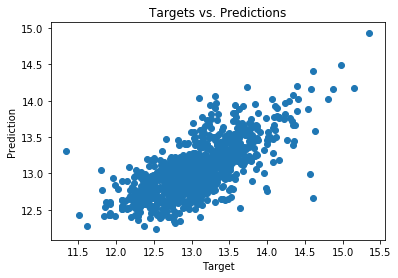

In [188]:
trainer_reg = TrainerRegression(
    units=2048,
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    n_layers=2,
    loss_function='mean_squared_error'
)
trainer_reg.train(x_train, y_train, 
                  batch_size=64,
                  epochs=200)
trainer_reg.print_summary()
trainer_reg.plot_history()
trainer_reg.evaluate(x_test, y_test)

Epoch 1/200
49/49 [==============================] - 1s 11ms/step - loss: 13.0118 - mean_squared_error: 169.6030 - mean_absolute_error: 13.0118 - val_loss: 12.9366 - val_mean_squared_error: 167.6563 - val_mean_absolute_error: 12.9366
Epoch 2/200
49/49 [==============================] - 0s 8ms/step - loss: 12.8954 - mean_squared_error: 166.5874 - mean_absolute_error: 12.8954 - val_loss: 12.8151 - val_mean_squared_error: 164.5284 - val_mean_absolute_error: 12.8151
Epoch 3/200
49/49 [==============================] - 0s 7ms/step - loss: 12.7708 - mean_squared_error: 163.3905 - mean_absolute_error: 12.7708 - val_loss: 12.6845 - val_mean_squared_error: 161.1965 - val_mean_absolute_error: 12.6845
Epoch 4/200
49/49 [==============================] - 0s 7ms/step - loss: 12.6328 - mean_squared_error: 159.8893 - mean_absolute_error: 12.6328 - val_loss: 12.5425 - val_mean_squared_error: 157.6161 - val_mean_absolute_error: 12.5425
Epoch 5/200
49/49 [==============================] - 0s 7ms/step - 

49/49 [==============================] - 0s 6ms/step - loss: 1.5089 - mean_squared_error: 12.7136 - mean_absolute_error: 1.5089 - val_loss: 1.1034 - val_mean_squared_error: 1.4925 - val_mean_absolute_error: 1.1034
Epoch 73/200
49/49 [==============================] - 0s 6ms/step - loss: 1.5112 - mean_squared_error: 12.6461 - mean_absolute_error: 1.5112 - val_loss: 1.0936 - val_mean_squared_error: 1.4703 - val_mean_absolute_error: 1.0936
Epoch 74/200
49/49 [==============================] - 0s 6ms/step - loss: 1.4143 - mean_squared_error: 11.5775 - mean_absolute_error: 1.4143 - val_loss: 1.0952 - val_mean_squared_error: 1.4741 - val_mean_absolute_error: 1.0952
Epoch 75/200
49/49 [==============================] - 0s 6ms/step - loss: 1.3932 - mean_squared_error: 11.2632 - mean_absolute_error: 1.3932 - val_loss: 1.0896 - val_mean_squared_error: 1.4613 - val_mean_absolute_error: 1.0896
Epoch 76/200
49/49 [==============================] - 0s 6ms/step - loss: 1.4984 - mean_squared_error: 12

 dense_621 (Dense)           (None, 1)                 2         
                                                                 
Total params: 23,326
Trainable params: 13,997
Non-trainable params: 9,329
_________________________________________________________________
None


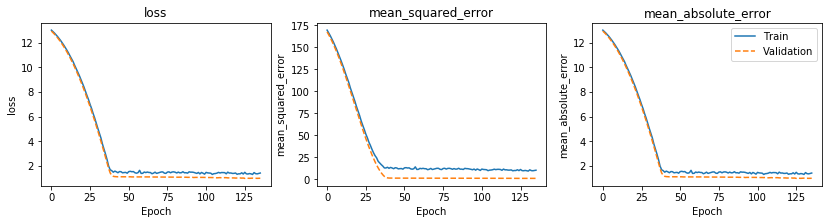

29/29 [==============================] - 0s 4ms/step - loss: 0.9995 - mean_squared_error: 1.2733 - mean_absolute_error: 0.9995
Test Loss: 0.9995102286338806 Test MSE: 1.273334264755249 Test MAE: 0.9995102286338806


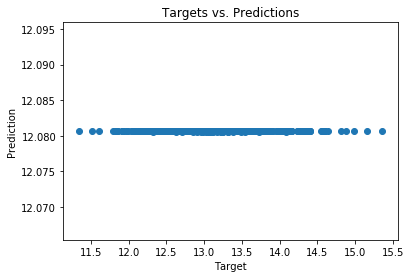

In [196]:
trainer_reg = TrainerRegression(
    units=2048,
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    n_layers=2,
    loss_function='mean_absolute_error'
)
trainer_reg.train(x_train, y_train, 
                  batch_size=64,
                  epochs=200)
trainer_reg.print_summary()
trainer_reg.plot_history()
trainer_reg.evaluate(x_test, y_test)

## Bonus

Test MSE: 0.07270271565619392 Test MAE: 0.16270201395509556


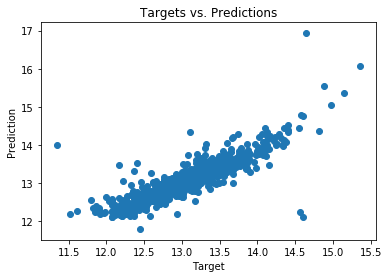

In [195]:
from sklearn.linear_model import Ridge

def evaluate(x_test, y_test, y_pred):
    print("Test MSE:", np.sum((y_pred - y_test) ** 2) / len(y_test),
          "Test MAE:", np.sum(np.abs(y_pred - y_test)) / len(y_test)
    )
    plt.title('Targets vs. Predictions')
    plt.scatter(y_test, y_pred)
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.show()

clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)
evaluate(x_test, y_test, clf.predict(x_test))

# Q3 - Dimensionality Reduction

## a)

In [109]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

def onehot(a):
    a = a.flatten()
    o = np.zeros((a.size, a.max() + 1))
    o[np.arange(a.size), a] = 1
    return o

def preprocess(x, y):
    assert x.shape[1:] == (32, 32, 3)
    assert y.shape[1:] == (1, )
    x = np.mean(x, axis=-1)  # grayscale
    x = np.reshape(x, (-1, 32 * 32))  # flatten
    x /= 255  # normalize
    y = onehot(y)  # onehot labels
    return x, y

x_train_processed, y_train_processed = preprocess(x_train, y_train)
x_test_processed, y_test_processed = preprocess(x_test, y_test)
x_train_processed.shape, y_train_processed.shape

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)


((50000, 1024), (50000, 10))

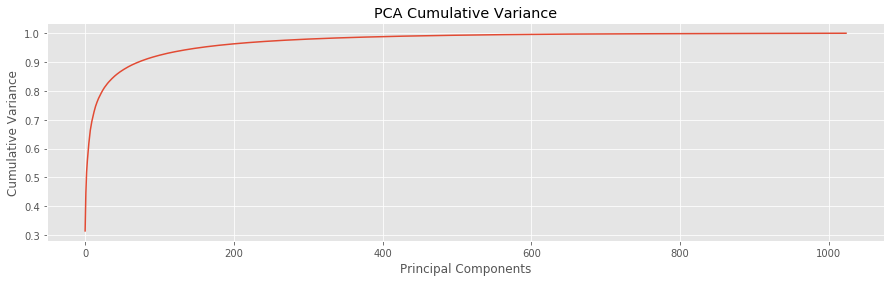

In [110]:
x_train_processed = (x_train_processed - x_train_processed.mean()) / x_train_processed.std()
x_test_processed = (x_test_processed - x_test_processed.mean()) / x_test_processed.std()
cov_mat = np.dot(x_train_processed.T, x_train_processed)
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

# Each feature explained variance
explained_variance = [ev / np.sum(eigenvalues) for ev in eigenvalues]
# Cumulative Variance
cumulative_variance = [np.sum(explained_variance[:i+1]) for i in range(len(explained_variance))]

plt.style.use('ggplot')
plt.figure(figsize=(15, 4))
plt.plot(cumulative_variance)
plt.title('PCA Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.show()

In [115]:
x_train_processed_pca = np.dot(x_train_processed, eigenvectors[:200].T)
x_test_processed_pca = np.dot(x_test_processed, eigenvectors[:200].T)
x_train_processed_pca.shape

(50000, 200)

Epoch 1/500
313/313 [==============================] - 5s 11ms/step - loss: 1.9861 - accuracy: 0.2875 - val_loss: 1.8331 - val_accuracy: 0.3552
Epoch 2/500
313/313 [==============================] - 3s 10ms/step - loss: 1.8122 - accuracy: 0.3579 - val_loss: 1.7617 - val_accuracy: 0.3795
Epoch 3/500
313/313 [==============================] - 3s 10ms/step - loss: 1.7155 - accuracy: 0.3986 - val_loss: 1.6780 - val_accuracy: 0.4171
Epoch 4/500
313/313 [==============================] - 3s 11ms/step - loss: 1.6297 - accuracy: 0.4263 - val_loss: 1.6370 - val_accuracy: 0.4231
Epoch 5/500
313/313 [==============================] - 3s 10ms/step - loss: 1.5553 - accuracy: 0.4507 - val_loss: 1.5981 - val_accuracy: 0.4395
Epoch 6/500
313/313 [==============================] - 3s 11ms/step - loss: 1.4911 - accuracy: 0.4775 - val_loss: 1.5665 - val_accuracy: 0.4433
Epoch 7/500
313/313 [==============================] - 2s 6ms/step - loss: 1.4316 - accuracy: 0.4979 - val_loss: 1.5656 - val_accuracy: 

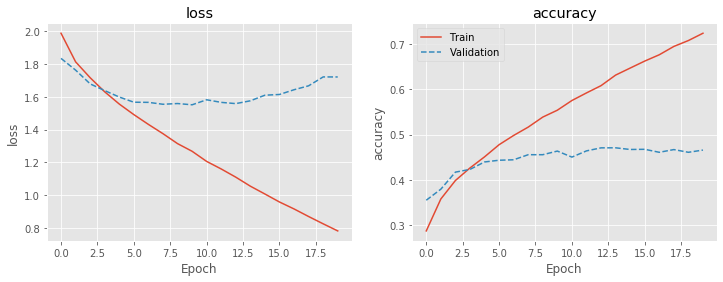

313/313 [==============================] - 1s 3ms/step - loss: 1.5508 - accuracy: 0.4600
Test Loss: 1.5507643222808838 Test Accuracy: 0.46000000834465027
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      1000
           1       0.54      0.56      0.55      1000
           2       0.37      0.37      0.37      1000
           3       0.31      0.32      0.31      1000
           4       0.40      0.35      0.37      1000
           5       0.44      0.35      0.39      1000
           6       0.44      0.58      0.50      1000
           7       0.52      0.54      0.53      1000
           8       0.54      0.62      0.57      1000
           9       0.52      0.47      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



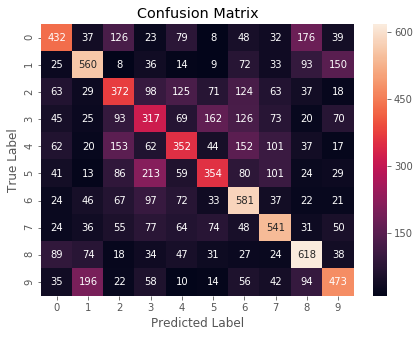

In [120]:
### BEST PCA
trainer = Trainer(
    units=1024,
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
    n_layers=4,
    loss_function = "kl_divergence",
    input_size=200
)
trainer.train(x_train_processed_pca, y_train_processed, 
              batch_size=128, 
              epochs=500)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed_pca, y_test_processed)

## b)

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_91 (Dense)            (None, 200)               205000    
                                                                 
 dense_92 (Dense)            (None, 1024)              205824    
                                                                 
Total params: 410,824
Trainable params: 410,824
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
313/313 [==============================] - 2s 5ms/step - loss: 0.2447 - val_loss: 0.1356
Epoch 2/50
313/313 [==============================] - 1s 5ms/step - loss: 0.1142 - val_loss: 0.1046
Epoch 3/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0909 - val_loss: 0.0840
Epoch 4/50


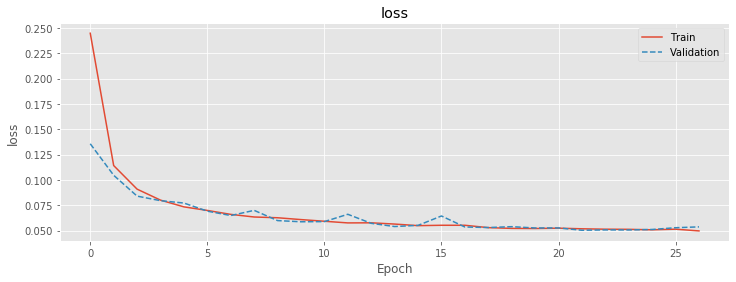

In [168]:
class TraineAutoencoder:
    def __init__(self) -> None:
        self.model = self.build_autoencoder_model()
        self.history = None
        self.training_time = None

    def build_autoencoder_model(self):
        self.input_ = tf.keras.Input(shape=(1024,))
        self.encoded = tf.keras.layers.Dense(200, activation='tanh')(self.input_)
        self.decoded = tf.keras.layers.Dense(1024)(self.encoded)
        autoencoder = tf.keras.Model(self.input_, self.decoded)
        autoencoder.compile(
            optimizer="adam", 
            loss='mean_squared_error'
        )
        return autoencoder
    
    def encode(self, x_test):
        encoder = tf.keras.Model(self.input_, self.encoded)
        encoded_inputs = encoder.predict(x_test)
        return encoded_inputs
    
    def train(self, x_train, batch_size=128, epochs=50):
        print(self.model.summary())
        self.batch_size = batch_size
        assert x_train.shape[1:] == (1024, )
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, x_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 1, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()
        
ta = TraineAutoencoder()
ta.train(x_train_processed, batch_size=128, epochs=50)
ta.plot_history()

In [169]:
x_train_processed_autoencoder = ta.encode(x_train_processed)
x_test_processed_autoencoder = ta.encode(x_test_processed)
x_train_processed_autoencoder.shape

(50000, 200)

Epoch 1/500
313/313 [==============================] - 4s 11ms/step - loss: 1.9939 - accuracy: 0.2854 - val_loss: 1.8223 - val_accuracy: 0.3554
Epoch 2/500
313/313 [==============================] - 3s 10ms/step - loss: 1.7659 - accuracy: 0.3732 - val_loss: 1.7020 - val_accuracy: 0.3976
Epoch 3/500
313/313 [==============================] - 3s 10ms/step - loss: 1.6254 - accuracy: 0.4227 - val_loss: 1.6144 - val_accuracy: 0.4304
Epoch 4/500
313/313 [==============================] - 3s 10ms/step - loss: 1.5034 - accuracy: 0.4686 - val_loss: 1.5572 - val_accuracy: 0.4497
Epoch 5/500
313/313 [==============================] - 3s 10ms/step - loss: 1.3956 - accuracy: 0.5059 - val_loss: 1.5346 - val_accuracy: 0.4569
Epoch 6/500
313/313 [==============================] - 3s 10ms/step - loss: 1.3006 - accuracy: 0.5400 - val_loss: 1.5199 - val_accuracy: 0.4666
Epoch 7/500
313/313 [==============================] - 3s 10ms/step - loss: 1.2135 - accuracy: 0.5701 - val_loss: 1.4963 - val_accuracy:

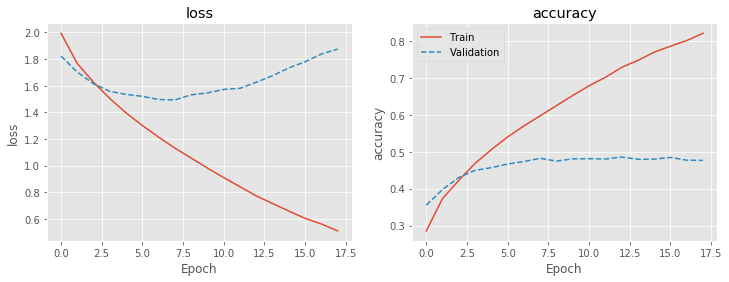

313/313 [==============================] - 1s 3ms/step - loss: 1.4857 - accuracy: 0.4720
Test Loss: 1.4856510162353516 Test Accuracy: 0.47200000286102295
              precision    recall  f1-score   support

           0       0.59      0.46      0.51      1000
           1       0.58      0.52      0.55      1000
           2       0.40      0.30      0.34      1000
           3       0.33      0.26      0.29      1000
           4       0.37      0.44      0.40      1000
           5       0.44      0.38      0.41      1000
           6       0.47      0.56      0.51      1000
           7       0.53      0.57      0.55      1000
           8       0.51      0.67      0.58      1000
           9       0.50      0.56      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



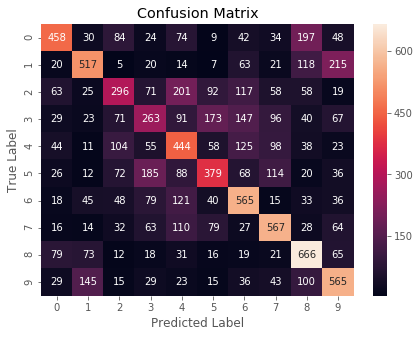

In [170]:
### BEST AC
trainer = Trainer(
    units=1024,
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
    n_layers=4,
    loss_function = "kl_divergence",
    input_size=200
)
trainer.train(x_train_processed_autoencoder, y_train_processed, 
              batch_size=128, 
              epochs=500)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed_autoencoder, y_test_processed)

## g)

## d)

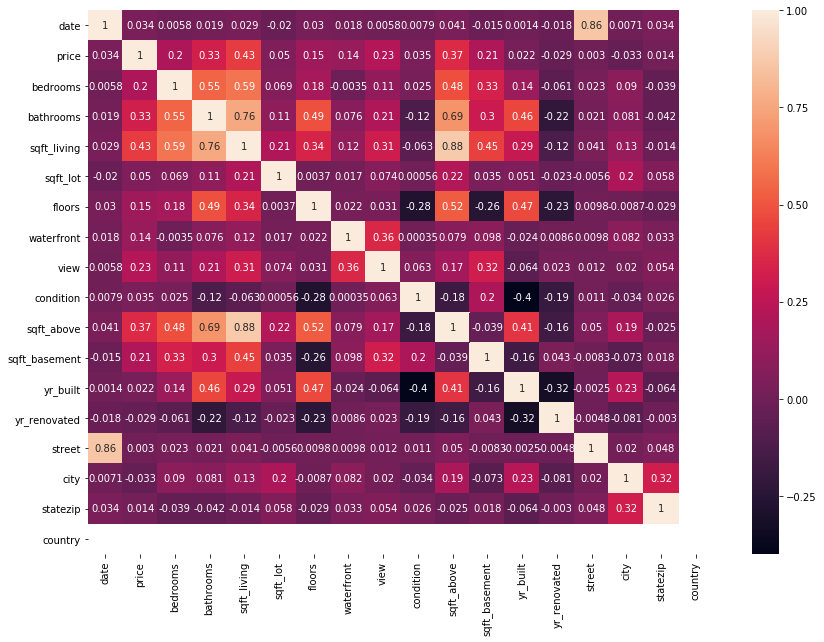

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,-1.833514,-0.423817,-0.441074,-0.843112,-0.829881,-0.193413,-0.022414,-0.084995,-0.309161,-0.667040,-0.565162,-0.672391,-0.530956,1.221538,-1.721431,-0.932755,-1.580132,NaN
1,-1.833514,3.249245,1.759513,0.432754,1.568358,-0.161700,0.906456,-0.084995,4.829554,2.286168,1.789365,-0.069121,-1.674511,-0.825604,-1.720665,-0.823617,-1.529230,NaN
2,-1.833514,-0.372384,-0.441074,-0.205179,-0.217344,-0.080969,-0.951284,-0.084995,-0.309161,0.809564,0.119158,-0.672391,-0.160982,-0.825604,-1.719899,-0.714478,-1.478328,NaN
3,-1.833514,-0.234046,-0.441074,0.113788,-0.144670,-0.190125,-0.951284,-0.084995,-0.309161,0.809564,-0.959517,1.482145,-0.261884,-0.825604,-1.719134,-0.605340,-1.427425,NaN
4,-1.833514,-0.003481,0.659220,0.432754,-0.206962,-0.121293,-0.951284,-0.084995,-0.309161,0.809564,-0.797135,1.051238,0.175357,1.208264,-1.718368,-0.496201,-1.376523,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,1.616831,-0.432390,-0.441074,-0.524145,-0.653387,-0.236663,-0.951284,-0.084995,-0.309161,0.809564,-0.367985,-0.672391,-0.564590,1.194991,1.739401,-0.823617,-1.580132,NaN
4596,1.616831,-0.031267,-0.441074,0.432754,-0.705297,-0.202860,0.906456,-0.084995,-0.309161,-0.667040,-0.425978,-0.672391,0.410795,1.225622,1.740167,-0.605340,-0.969304,NaN
4597,1.616831,-0.239536,-0.441074,0.432754,0.903911,-0.218438,0.906456,-0.084995,-0.309161,-0.667040,1.371813,-0.672391,1.285278,-0.825604,1.740932,1.031739,0.150549,NaN
4598,1.667571,-0.618201,0.659220,-0.205179,-0.051232,-0.229139,-0.951284,-0.084995,-0.309161,-0.667040,-0.878326,1.525235,0.108089,-0.825604,1.741698,-0.823617,1.728524,NaN


In [45]:
df = pd.read_csv('data.csv')
CAT_COLS = ["date", "street", "city", "statezip", "country"]
for cat_col in CAT_COLS:
    df[cat_col] = pd.factorize(df[cat_col])[0]
df = (df-df.mean()) / df.std()

corr = df.corr()
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

df

## v)

<BarContainer object of 16 artists>

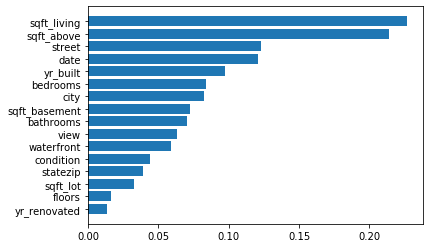

In [62]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

features = df.drop(["price", "country"], axis=1)
regressor = LinearRegression()
regressor.fit(features, df["price"])
intercept = regressor.intercept_

reg_importance = pd.DataFrame(zip(features.columns, np.abs(regressor.coef_)), columns=["feature", "coef"])
reg_importance = reg_importance.sort_values(by='coef', ascending=True)
plt.barh(reg_importance["feature"], reg_importance["coef"])

<BarContainer object of 16 artists>

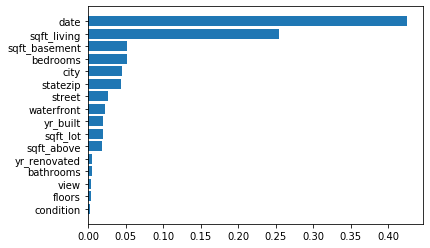

In [64]:
features = df.drop(["price", "country"], axis=1)
regressor = DecisionTreeRegressor()
regressor.fit(features, df["price"])

reg_importance = pd.DataFrame(zip(features.columns, regressor.feature_importances_), columns=["feature", "importance"])
reg_importance = reg_importance.sort_values(by='importance', ascending=True)
plt.barh(reg_importance["feature"], reg_importance["importance"])